# Importing Libraries for Data Processing, Model Building

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow
import os
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

# load dataset

In [7]:
train_images = os.listdir(r"C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-cats\train\train") 
CATEGORIES = [] 
image_path = []
for image_name in train_images:  
    class_name = image_name.split('.')[0]  
    CATEGORIES.append(0 if class_name == 'cat' else 1)  
    image_path.append(os.path.join(r"C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-cats\train\train", image_name) )

df = pd.DataFrame({"train_images": image_path, "CATEGORIES": CATEGORIES})

In [37]:
df["CATEGORIES"] = df["CATEGORIES"].replace({0: 'cat', 1: 'dog'})

In [38]:
df.head() 

,train_images,CATEGORIES
0,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat
1,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat
2,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat
3,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat
4,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat


In [39]:
df.describe()

,train_images,CATEGORIES
count,25000,25000
unique,25000,2
top,C:\Users\PMYLS\OneDrive\Desktop\NLP\dogs-vs-ca...,cat
freq,1,12500


In [40]:
df["CATEGORIES"].value_counts() 

CATEGORIES
cat    12500
dog    12500
Name: count, dtype: int64

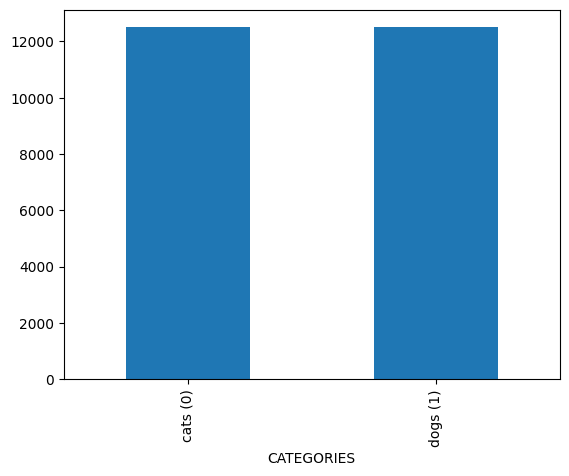

In [41]:
df["CATEGORIES"].value_counts().plot.bar() 
plt.xticks([0, 1], ['cats (0)', 'dogs (1)'])
plt.show()

In [23]:
labels = ["Cat", "Dog"]

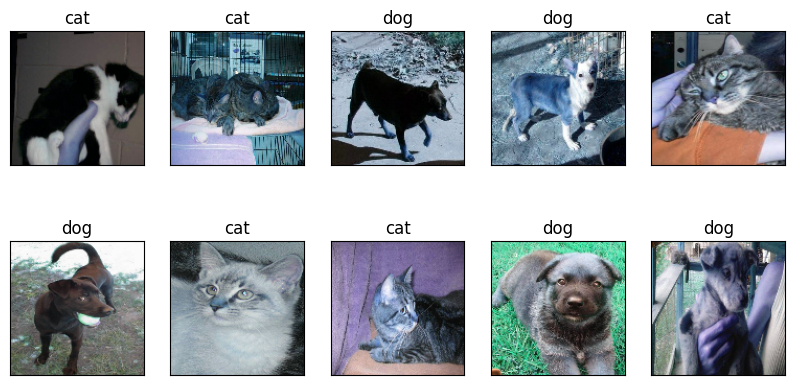

In [44]:
plt.figure(figsize=(10,5))

for i in range(0,10):
   num = np.random.randint(1, len(df))
   axes = plt.subplot(2, 5, i + 1)
   img = df["train_images"][num]
   img = cv2.imread(img)
   resize_img = cv2.resize(img, (128,128))

   axes.imshow(resize_img)
   axes.get_xaxis().set_visible(False)
   axes.get_yaxis().set_visible(False)
   plt.title(df["CATEGORIES"][num])

In [51]:
train_df,  test_df= train_test_split(df, test_size=0.20, random_state=42) 

In [52]:
test_df,  val_df= train_test_split(test_df, test_size=0.5, random_state=42) 

In [53]:
datagen = ImageDataGenerator(
    rescale=1.0/255,             # Normalize pixel values (0-1 range)
    rotation_range=20,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Randomly zoom in on images
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # How to fill in new pixels
)


In [54]:
IMAGE_WIDTH = 128  # El ancho de cada imagen que vamos a usar.
IMAGE_HEIGHT = 128  # La altura de cada imagen que vamos a usar.
IMAGE_CHANNELS = 3  # Indica que las imágenes son a color (3 colores: rojo, verde, azul).
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

In [65]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='train_images',          # Column with image paths
    y_col='CATEGORIES',             # Column with class labels
    target_size=IMAGE_SIZE,    # Resize all images to 224x224
    batch_size=64,             # Number of images in each batch
    class_mode='binary'   # For multi-class classification
)

Found 20000 validated image filenames belonging to 2 classes.


In [64]:
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='train_images',          # Column with image paths
    y_col='CATEGORIES',             # Column with class labels
    target_size=IMAGE_SIZE,    # Resize all images to 224x224
    batch_size=64,             # Number of images in each batch
    class_mode='binary'   # For multi-class classification
)

Found 2500 validated image filenames belonging to 2 classes.


In [63]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='train_images',          # Column with image paths
    y_col='CATEGORIES',             # Column with class labels
    target_size=IMAGE_SIZE,    # Resize all images to 224x224
    batch_size=64,             # Number of images in each batch
    class_mode='binary'   # For multi-class classification
)

Found 2500 validated image filenames belonging to 2 classes.


In [67]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Load the ResNet50 model pre-trained on ImageNet, exclude the top layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the initial layers to retain learned features (optional, based on preference)
for layer in resnet.layers[:143]:  # Keep first 143 layers frozen
    layer.trainable = False

# Unfreeze some deeper layers for fine-tuning
for layer in resnet.layers[143:]:  # Unfreeze deeper layers for fine-tuning
    layer.trainable = True

# Add custom classification layers on top of ResNet50
x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Define the final model
model = Model(inputs=resnet.input, outputs=output)

# Compile the model using SGD optimizer with a low learning rate
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 40,365,953 (153.98 MB)

 Trainable params: 31,754,241 (121.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [69]:
history = model.fit(train_generator, 
                    epochs=5, 
                    validation_data=val_generator, 
                    steps_per_epoch=100, 
                    validation_steps=50)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.5557 - loss: 0.7878 - val_accuracy: 0.5112 - val_loss: 0.6990
Epoch 2/5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1776.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


100/100 ━━━━━━━━━━━━━━━━━━━━ 690s 7s/step - accuracy: 0.6123 - loss: 0.6696 - val_accuracy: 0.5456 - val_loss: 0.6889
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1504s 15s/step - accuracy: 0.6170 - loss: 0.6552 - val_accuracy: 0.6240 - val_loss: 0.6487
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 785ms/step - accuracy: 0.6203 - loss: 0.6436 - val_accuracy: 0.6180 - val_loss: 0.6498
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.6370 - loss: 0.6348 - val_accuracy: 0.6380 - val_loss: 0.6313


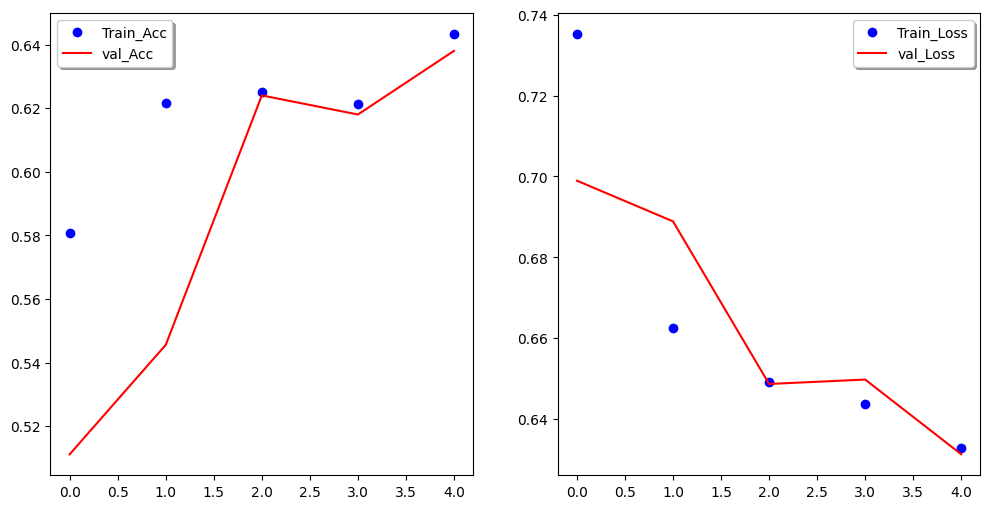

In [71]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(accuracy))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, accuracy, 'bo', label="Train_Acc")
plt.plot(epochs, val_accuracy, 'r', label="val_Acc")
plt.legend(loc='best', shadow=True)

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label="Train_Loss")
plt.plot(epochs, val_loss, 'r', label="val_Loss")
plt.legend(loc='best', shadow=True)

plt.show()


In [73]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

C:\Users\PMYLS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6617 - loss: 0.6161
Validation Accuracy: 65.92%


In [88]:
y_true = test_generator.classes 

In [89]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  

40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step


In [91]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Print a detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

Precision: 0.50
Recall: 0.55

Classification Report:
               precision    recall  f1-score   support

         Cat       0.52      0.47      0.49      1267
         Dog       0.50      0.55      0.52      1233

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
[[0.68765604]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[[0.756628]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
[[0.6946727]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[[0.7343197]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.68183774]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
[[0.35470128]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
[[0.50592804]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
[[0.4456809]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
[[0.31627938]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[0.66964245]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[0.40329805]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[0.8269886]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[[0.738819]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
[[0.43266767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[[0.38715565]]


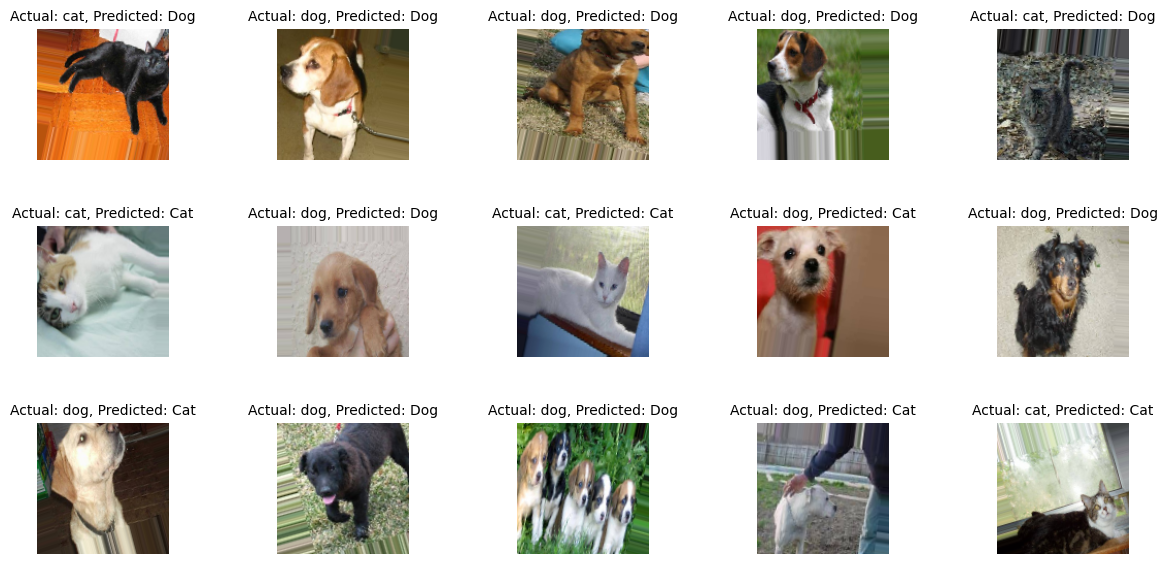

In [86]:

class_labels = list(test_generator.class_indices.keys())
# Assume x_test, y_test, predictions, and fashion_mnist_labels are defined
plt.figure(figsize=(12, 6))  # Increase the figure size
for i in range(15):
    plt.subplot(3, 5, i + 1)
    image, label = next(test_generator)
    random_index = np.random.randint(0, len(image) - 1)
    random_image = image[random_index]
    true_label = label[random_index]
    predicted_prob = model.predict(np.expand_dims(random_image, axis=0))
    print(predicted_prob)
    predicted_label = "Dog" if predicted_prob[0] > 0.5 else "Cat"
    # predicted_label = np.argmax(predicted_prob)
    plt.imshow(random_image, cmap='gray')  # Reshape back to 28x28
    plt.title(f"Actual: {class_labels[int(true_label)]}, Predicted: {predicted_label}", fontsize=10)  # Adjust title font size
    plt.axis('off')

plt.tight_layout(pad=2.0)  # Adjust the layout
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust spacing
plt.show()